<a href="https://colab.research.google.com/github/duonghung86/Injury-severity-classification/blob/main/VCA_2_1_MLP_earlystopping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from psutil import virtual_memory,cpu_percent
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
print('Current system-wide CPU utilization %: ',cpu_percent())
#Remove all warning
import warnings
warnings.filterwarnings("ignore")

Your runtime has 270.0 gigabytes of available RAM

Current system-wide CPU utilization %:  0.0


In [2]:
# Basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
from collections import Counter
# Preprocessing
from sklearn.preprocessing import StandardScaler # Standardization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Machine learning algos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# Imblearn
from imblearn.metrics import geometric_mean_score
from imblearn.over_sampling import SMOTE, RandomOverSampler,BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler,NearMiss,EditedNearestNeighbours

# Grid search
from kerastuner.tuners import RandomSearch,Hyperband,BayesianOptimization
import kerastuner as kt
from tensorflow.keras.optimizers import Adam
# Tensorflow
import tensorflow as tf
print(tf.__version__)
from tensorflow import feature_column  # for data wrangling
from tensorflow.keras.losses import SparseCategoricalCrossentropy,CategoricalCrossentropy
from tensorflow.keras.layers import Dense,Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import SparseCategoricalAccuracy,CategoricalAccuracy
from tensorflow_addons.metrics import CohenKappa,F1Score


2.1.0


In [3]:
url = 'https://github.com/duonghung86/Injury-severity-classification/blob/main/Prepared%20Texas%202019.zip?raw=true' 
data_path = tf.keras.utils.get_file(origin=url, fname=url.split('/')[-1].split('?')[0], extract=True)
data_path = data_path.replace('%20',' ').replace('.zip','.csv')

In [4]:
# Load data
df = pd.read_csv(data_path)
print(df.shape)
df.head(3)

(949856, 19)


,Prsn_Injry_Sev,Prsn_Age,Prsn_Gndr,Wthr_Cond,Light_Cond,Surf_Cond,Veh_Body_Styl,Prsn_Rest,Prsn_Drg_Rslt,Harm_Evnt,Rural,Crash_Speed_Limit,Road_Algn,Veh_Mod_Year,Weekend,Crash_season,Part_of_day,Collsn_type,Collsn_name
0,0,26,MALE,CLEAR,DAYLIGHT,DRY,"PASSENGER CAR, 2-DOOR",SHOULDER & LAP BELT,Not Applicable,MOTOR VEHICLE IN TRANSPORT,0,-1,"STRAIGHT, LEVEL",33,1,3,3,SAME DIRECTION,ONE STRAIGHT-ONE LEFT TURN
1,0,52,MALE,CLEAR,DAYLIGHT,DRY,"PASSENGER CAR, 2-DOOR",SHOULDER & LAP BELT,Not Applicable,MOTOR VEHICLE IN TRANSPORT,0,-1,"STRAIGHT, LEVEL",19,1,3,3,SAME DIRECTION,ONE STRAIGHT-ONE LEFT TURN
2,0,27,FEMALE,CLEAR,DAYLIGHT,DRY,PICKUP,SHOULDER & LAP BELT,Not Applicable,MOTOR VEHICLE IN TRANSPORT,1,-1,"CURVE, LEVEL",16,1,3,4,SAME DIRECTION,BOTH LEFT TURN


In [5]:
# Let's just use 80% of the total dataset
#df, _ = train_test_split(df, test_size=0.9,stratify = df['Prsn_Injry_Sev'])
df.shape

(949856, 19)

In [6]:
y = df['Prsn_Injry_Sev']
print('All target values:')
print(y.value_counts())
X = df.drop(columns=['Prsn_Injry_Sev'])

All target values:
0    792558
1    102409
2     45242
3      7951
4      1696
Name: Prsn_Injry_Sev, dtype: int64


In [7]:
# %% Data wrangling -------------
# Classify variable type
emb_vars, ind_vars, num_vars = [], [], []
for var in X.columns:
    if X[var].dtypes == 'O':
        if len(X[var].unique()) > 5:
            emb_vars.append(var)
        else:
            ind_vars.append(var)
    else:
        num_vars.append(var)
print('Numerical variables are ', num_vars)
print('Categorical variables that have at most 5 categories are ', ind_vars)
print('Categorical variables that have more than 5 categories are ', emb_vars)

# Create feature columns
feature_columns = []
# numeric cols
for header in num_vars:
    feature_columns.append(feature_column.numeric_column(header))
# bucketized cols
# age = feature_column.numeric_column('Prsn_Age')
# age_buckets = feature_column.bucketized_column(age, boundaries=[16, 22, 35, 55, 65])
# feature_columns.append(age_buckets)
# indicator_columns
for col_name in ind_vars:
    categorical_column = feature_column.categorical_column_with_vocabulary_list(
        col_name, X[col_name].unique())
    indicator_column = feature_column.indicator_column(categorical_column)
    feature_columns.append(indicator_column)
# embedding columns
for col_name in emb_vars:
    emb_column = feature_column.categorical_column_with_vocabulary_list(
        col_name, X[col_name].unique())
    col_embedding = feature_column.embedding_column(emb_column, dimension=5)
    feature_columns.append(col_embedding)

# Convert all setup into new dataset
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
X = feature_layer(dict(X)).numpy()
print('New shape of the input data set:',X.shape)

Numerical variables are  ['Prsn_Age', 'Rural', 'Crash_Speed_Limit', 'Veh_Mod_Year', 'Weekend', 'Crash_season', 'Part_of_day']
Categorical variables that have at most 5 categories are  ['Prsn_Gndr', 'Prsn_Drg_Rslt', 'Collsn_type']
Categorical variables that have more than 5 categories are  ['Wthr_Cond', 'Light_Cond', 'Surf_Cond', 'Veh_Body_Styl', 'Prsn_Rest', 'Harm_Evnt', 'Road_Algn', 'Collsn_name']
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
New shape of the input data set: (949856, 59)


In [8]:
# %% Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=48)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=48)

print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
print('Test features shape:', X_test.shape)

# %% standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

Training features shape: (607907, 59)
Validation features shape: (151977, 59)
Test features shape: (189972, 59)


# ALL mini functions



In [9]:
# Import Metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score

# %% Function to compare the prediction and true labels
def get_accs(label, pred_proba, tr_time=0,index=None):
    prediction = pred_proba.argmax(axis=1)
    cm = confusion_matrix(label, prediction)
    length = cm.shape[0]
    num_cases = len(label)
    # global accuracy
    glb_acc = np.trace(cm) / len(label)
    ind_accs = cm / np.sum(cm, axis=1)[:, np.newaxis]
    accs = [ind_accs[i, i] for i in range(length)]
    cols = ['Class {}'.format(i) for i in range(length)]
    # Global accuracy
    accs.append(glb_acc)
    # AUC
    accs.append(roc_auc_score(label, pred_proba,multi_class='ovr'))
    # G-mean
    accs.append(geometric_mean_score(label, prediction, correction=0.001))
    # Average perf
    accs.append(np.mean(accs[-3:]))
    # Training time
    accs.append(np.round(tr_time,3))
    cols = cols + ['Accuracy','AUC','G-mean','OP score','Tuning Time']

    out = np.array(accs).reshape(1, len(accs))
    return pd.DataFrame(out, columns=cols,index=[index])

# ML with class weight

# MLP functions


In [10]:
# Add weights
weights = len(y_train) / (5 * np.bincount(y_train))
cls_wgt = dict(zip(np.arange(5), weights))
cls_wgt

{0: 0.23969347661941065,
 1: 1.8550434079431195,
 2: 4.199122746425364,
 3: 23.891019846728238,
 4: 111.95340699815839}

In [11]:
def early_stops(metric_name):
    es = EarlyStopping(monitor='val_'+ metric_name,
                   verbose=1, patience=10, mode='max',
                   restore_best_weights=True)
    return es

In [12]:
# Constant
EPOCH = 50
BATCH_SIZE = 2048
VERBOSE = 0

In [13]:
METRICS = [SparseCategoricalAccuracy(name='accuracy')]
def create_mlp():
    MLP = Sequential([Dense(10,
                           activation='relu',
                           input_dim=X_train.shape[1],
                           ),
                      Dropout(0.5),
                      Dense(5, activation='softmax')])
    MLP.compile(optimizer='adam',
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=METRICS
               )
    return MLP

# Hybrid Resampling 

In [14]:
y_dict = Counter(y_train)
def hyb_sam(random=12):
    start = time.time()
    res = RandomUnderSampler(random_state = random, sampling_strategy={0: y_dict[1]})
    print('under sampling ...')
    X_sam, y_sam = res.fit_resample(X_train, y_train)
    print(Counter(y_sam))
    print('over sampling #2 ...')
    res = SMOTE(random_state = random,sampling_strategy='not majority')
    X_sam, y_sam = res.fit_resample(X_sam, y_sam)
    end = time.time()
    res_time = end-start
    print('Resampling time is %.2f' % res_time)
    return X_sam, y_sam

In [15]:
X_res, y_res = hyb_sam()

under sampling ...
Counter({0: 65541, 1: 65541, 2: 28954, 3: 5089, 4: 1086})
over sampling #2 ...
Resampling time is 61.33


# MLP with Hybrid Sampling

In [16]:
rsts = pd.DataFrame()
for i in range(3):
    model = create_mlp()
    start = time.time()
    monitor = model.fit(X_res, y_res,
                        callbacks=[early_stops('accuracy')],
                        validation_data=(X_val,y_val),
                        batch_size=BATCH_SIZE,
                        verbose=VERBOSE, epochs=EPOCH
                       )
    end = time.time()
    # use the model to make predictions with the test data
    Y_pred = model.predict(X_test)
    rsts = rsts.append(get_accs(y_test.values,Y_pred,end-start,'MLP-Weights-'+str(i+1)))
print(rsts.iloc[:,5:])

Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
               Accuracy       AUC    G-mean  OP score  Tuning Time
MLP-Weights-1  0.521666  0.686325  0.320963  0.509651        6.061
MLP-Weights-2  0.486672  0.706244  0.377903  0.523606       16.510
MLP-Weights-3  0.489214  0.711699  0.344512  0.515142        7.536


# Set up grid search

We will investigates the following parameters:

- Initial weights
- Activation function
- Number of nodes
- Dropout rate
- Early Stop
- Learning rate

# Keras tuner

In [17]:
def build_model(hp):
    hp_units = hp.Int('units', min_value=5, max_value=20, step=5)
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    hp_dos = hp.Float('dropouts',min_value=0.2, max_value=0.5, step=0.1)
    hp_acts = hp.Choice('activation', values = ['relu','sigmoid','tanh','selu'])
    keins = ['uniform', 'normal', 'zeros', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
    hp_keins = hp.Choice('kernel_ini', values = keins) 
    model = Sequential([Dense(hp_units,
                           activation=hp_acts,
                           input_dim=X_train.shape[1],
                            kernel_initializer= hp_keins 
                           ),
                      Dropout(hp_dos),
                      Dense(5, activation='softmax')])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=METRICS
               )
    return model

In [18]:
MAX_EPOCHS = 30
FACTOR = 3
TRIAL = 3
bps = pd.DataFrame()
obj = 'accuracy'
best_models=[]

In [19]:
for i in range(TRIAL):
    tuner = Hyperband(build_model,
                         objective = obj, 
                         max_epochs = MAX_EPOCHS,
                         factor = FACTOR,
                         directory = 'my_dir',
                         project_name = 'val_'+ obj+'_'+time.ctime())
    tuner.search(X_res, y_res,
                 epochs=MAX_EPOCHS,batch_size=2048,
                 verbose=0,
                 callbacks=[early_stops(obj)],
                 validation_data=(X_val, y_val))
    end = time.time()

    print('Tuning time is %.2f' % (end-start))
    print(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values)
    bp = pd.Series(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values,name='HB')
    bps = pd.concat((bps,bp),axis=1)
    bm = tuner.get_best_models(num_models=1)[0]
    best_models.append(bm)
    Y_pred = bm.predict(X_test)
    performance = get_accs(y_test.values,Y_pred,end-start,'HB-'+str(i+1))
    print(performance.iloc[:,5:])
    rsts = rsts.append(performance)
print(bps)
print(rsts.iloc[:,5:])

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00011: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00014: early stopping
INFO:tensorflow:Oracle triggered exit
Tuning time is 327.82
{'units': 15, 'learning_rate': 0.01, 'dropouts': 0.2, 'activation': 'relu', 'kernel_ini': 'he_uniform', 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '93d6e44a36d5befdb905ae90c436e8da'}
      Accuracy       AUC 

## Random search

In [20]:
for i in range(TRIAL):
    tuner = RandomSearch(build_model,
                         objective = obj, 
                         max_trials = TRIAL,
                         directory = 'my_dir',
                         project_name = 'val_'+ obj+'_'+time.ctime())
    tuner.search(X_res, y_res,
                 epochs=MAX_EPOCHS,batch_size=2048,
                 verbose=0,
                 callbacks=[early_stops(obj)],
                 validation_data=(X_val, y_val))
    end = time.time()

    print('Tuning time is %.2f' % (end-start))
    print(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values)
    bp = pd.Series(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values,name='RS')
    bps = pd.concat((bps,bp),axis=1)
    bm = tuner.get_best_models(num_models=1)[0]
    best_models.append(bm)
    Y_pred = bm.predict(X_test)
    performance = get_accs(y_test.values,Y_pred,end-start,'RS-'+str(i+1))
    print(performance.iloc[:,5:])
    rsts = rsts.append(performance)
print(bps)
print(rsts.iloc[:,5:])

Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
INFO:tensorflow:Oracle triggered exit
Tuning time is 1006.93
{'units': 10, 'learning_rate': 0.01, 'dropouts': 0.5000000000000001, 'activation': 'tanh', 'kernel_ini': 'he_normal'}
      Accuracy       AUC   G-mean  OP score  Tuning Time
RS-1  0.491715  0.701702  0.33084  0.508086     1006.931
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
INFO:tensorflow:Oracle triggered exit
Tuning time is 1035.95
{'units': 20, 'learning_rate': 0.01, 'dropouts': 0.2, 'activation': 'tanh', 'kernel_ini': 'glorot_uniform'}
      Accuracy       AUC    G-mean  OP score  Tuning Time
RS-2  0.467532  0.709645  0.387077  0.521418     1035.954
Re

## BayesianOptimization

In [21]:
for i in range(TRIAL):
    tuner = BayesianOptimization(build_model,
                         objective = obj, 
                         max_trials = TRIAL,
                         directory = 'my_dir',
                         project_name = 'val_'+ obj+'_'+time.ctime())
    tuner.search(X_res, y_res,
                 epochs=MAX_EPOCHS,batch_size=2048,
                 verbose=0,
                 callbacks=[early_stops(obj)],
                 validation_data=(X_val, y_val))
    end = time.time()

    print('Tuning time is %.2f' % (end-start))
    print(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values)
    bp = pd.Series(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values,name='BO')
    bps = pd.concat((bps,bp),axis=1)
    bm = tuner.get_best_models(num_models=1)[0]
    best_models.append(bm)
    Y_pred = bm.predict(X_test)
    performance = get_accs(y_test.values,Y_pred,end-start,'BO-'+str(i+1))
    print(performance.iloc[:,5:])
    rsts = rsts.append(performance)
print(bps)
print(rsts.iloc[:,5:])

Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
INFO:tensorflow:Oracle triggered exit
Tuning time is 1115.42
{'units': 15, 'learning_rate': 0.01, 'dropouts': 0.2, 'activation': 'relu', 'kernel_ini': 'glorot_uniform'}
      Accuracy       AUC    G-mean  OP score  Tuning Time
BO-1  0.484419  0.714665  0.396414  0.531833     1115.419
INFO:tensorflow:Oracle triggered exit
Tuning time is 1168.07
{'units': 20, 'learning_rate': 0.0001, 'dropouts': 0.4000000000000001, 'activation': 'tanh', 'kernel_ini': 'uniform'}
      Accuracy       AUC    G-mean  OP score  Tuning Time
BO-2  0.495826  0.707617  0.355175  0.519539     1168.074
Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping
Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
INFO:tensorflow:Oracle triggered exit
Tuning time is 1214.43
{'units': 20, 'learning

In [22]:
bps.columns = ['HB']*3+['RS']*3+['BO']*3
bps.head(5)

,HB,HB,HB,RS,RS,RS,BO,BO,BO
units,15,20,20,10,20,10,15,20,20
learning_rate,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0001,0.01
dropouts,0.2,0.2,0.2,0.5,0.2,0.3,0.2,0.4,0.3
activation,relu,tanh,selu,tanh,tanh,relu,relu,tanh,sigmoid
kernel_ini,he_uniform,normal,glorot_uniform,he_normal,glorot_uniform,normal,glorot_uniform,uniform,he_uniform


In [23]:
rsts = rsts.reset_index()
rsts.head(3)

,index,Class 0,Class 1,Class 2,Class 3,Class 4,Accuracy,AUC,G-mean,OP score,Tuning Time
0,MLP-Weights-1,0.571439,0.341763,0.099016,0.231447,0.761062,0.521666,0.686325,0.320963,0.509651,6.061
1,MLP-Weights-2,0.518869,0.382189,0.185656,0.280503,0.746313,0.486672,0.706244,0.377903,0.523606,16.510
2,MLP-Weights-3,0.518068,0.447075,0.111283,0.250314,0.752212,0.489214,0.711699,0.344512,0.515142,7.536


In [24]:
rsts['index'] = ['Weights-1', 'Weights-2', 'Weights-3', 'HB-1', 'HB-2',
       'HB-3', 'RS-1', 'RS-2', 'RS-3', 'BO-1', 'BO-2', 'BO-3']
rsts

,index,Class 0,Class 1,Class 2,Class 3,Class 4,Accuracy,AUC,G-mean,OP score,Tuning Time
0,Weights-1,0.571439,0.341763,0.099016,0.231447,0.761062,0.521666,0.686325,0.320963,0.509651,6.061
1,Weights-2,0.518869,0.382189,0.185656,0.280503,0.746313,0.486672,0.706244,0.377903,0.523606,16.510
2,Weights-3,0.518068,0.447075,0.111283,0.250314,0.752212,0.489214,0.711699,0.344512,0.515142,7.536
3,HB-1,0.511804,0.397324,0.198696,0.364151,0.631268,0.483524,0.713395,0.392271,0.529730,327.822
4,HB-2,0.513343,0.431647,0.146646,0.361006,0.672566,0.486077,0.709638,0.379674,0.525130,654.784
5,HB-3,0.521285,0.367249,0.215935,0.335220,0.699115,0.488893,0.710629,0.395592,0.531705,972.059
6,RS-1,0.517412,0.487404,0.083877,0.254088,0.737463,0.491715,0.701702,0.330840,0.508086,1006.931
7,RS-2,0.491389,0.414754,0.185766,0.318868,0.719764,0.467532,0.709645,0.387077,0.521418,1035.954
8,RS-3,0.499817,0.381896,0.208752,0.344025,0.663717,0.472227,0.700641,0.390654,0.521174,1076.546
9,BO-1,0.514989,0.369007,0.226434,0.360377,0.631268,0.484419,0.714665,0.396414,0.531833,1115.419


In [25]:
indexing = rsts['index'].str.split('-',expand=True)
indexing.columns = ['Tuner','Trial']

In [26]:
rsts = pd.concat((rsts, indexing),axis =1)
rsts.head(3)

,index,Class 0,Class 1,Class 2,Class 3,Class 4,Accuracy,AUC,G-mean,OP score,Tuning Time,Tuner,Trial
0,Weights-1,0.571439,0.341763,0.099016,0.231447,0.761062,0.521666,0.686325,0.320963,0.509651,6.061,Weights,1
1,Weights-2,0.518869,0.382189,0.185656,0.280503,0.746313,0.486672,0.706244,0.377903,0.523606,16.510,Weights,2
2,Weights-3,0.518068,0.447075,0.111283,0.250314,0.752212,0.489214,0.711699,0.344512,0.515142,7.536,Weights,3


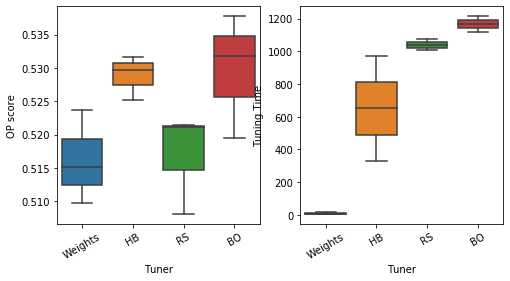

In [28]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.boxplot(data=rsts, x='Tuner',y='OP score')
plt.xticks(rotation=30)
plt.subplot(1,2,2)
sns.boxplot(data=rsts, x='Tuner',y='Tuning Time')
plt.xticks(rotation=30)
plt.savefig('Tuners.png',bbox_inches='tight',dpi=200)
plt.show()

In [29]:
tuning_rsts = rsts.iloc[3:,:]

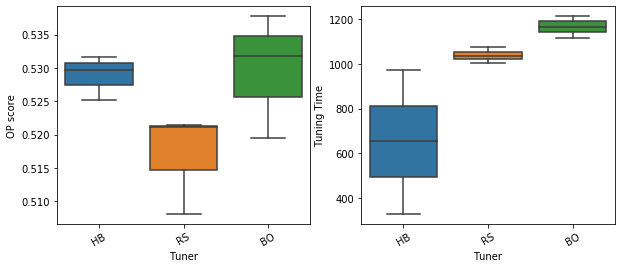

In [30]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(data=tuning_rsts, x='Tuner',y='OP score')
plt.xticks(rotation=30)
plt.subplot(1,2,2)
sns.boxplot(data=tuning_rsts, x='Tuner',y='Tuning Time')
plt.xticks(rotation=30)
plt.savefig('Tuners.png',bbox_inches='tight',dpi=200)
plt.show()

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
bestm = models[0]
bestm.save('saved_model/bestm')